<a href="https://colab.research.google.com/github/allykim308/others/blob/main/EX3_houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#필요한 라이브러리 import 하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#LMS에서 사용할 때 알맞은 파일 경로
train_data_path = "/content/gdrive/MyDrive/Colab Notebooks/ex3/train.csv"
test_data_path = "/content/gdrive/MyDrive/Colab Notebooks/ex3/test.csv"

In [ ]:
#데이터 불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [ ]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [ ]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

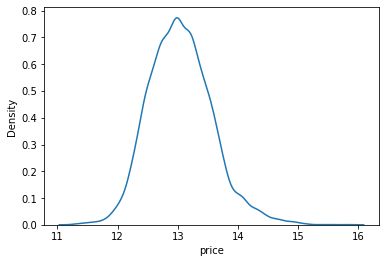

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
def get_scores(models, train, y):


  df = {}

  for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
  return df

get_scores(models, train, y)

[23:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 128360.19649691365,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562,
 'XGBRegressor': 131067.44622809246}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, 
                        scoring='neg_mean_squared_error', 
                        cv=5, verbose=1, n_jobs=5)

In [ ]:
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.27855158, 0.36634951, 0.92995763, 1.46061401]),
 'mean_score_time': array([0.02582326, 0.0311254 , 0.04827003, 0.07151227]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [ ]:
params = grid_model.cv_results_['params']
print(params)


[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]


In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [ ]:
# 여기에 코드를 작성하세요.'\\
import pandas as pd 
results = pd.DataFrame(params)
results['score'] = score

results


,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results['RMSE']

0    0.270914
1    0.234564
2    0.170814
3    0.164399
Name: RMSE, dtype: float64

In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [ ]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [ ]:
submission_path = '/content/gdrive/MyDrive/Colab Notebooks/ex3/sample_submission.csv'
print(submission_path)
submission = pd.read_csv(submission_path)
submission.head()

/content/gdrive/MyDrive/Colab Notebooks/ex3/sample_submission.csv


,id,price
0,15035,5.625664e+05
1,15036,3.896607e+05
2,15037,1.340643e+06
3,15038,3.317573e+05
4,15039,2.966855e+05


In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [ ]:
submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format('lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

submission_lgbm_RMSLE_0.164399.csv


In [ ]:

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = '/content/gdrive/MyDrive/Colab Notebooks/ex3/sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')
submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format('lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

submission_lgbm_RMSLE_0.0168.csv saved!
submission_lgbm_RMSLE_0.164399.csv


In [ ]:
# 하이퍼 파라미터 튜닝하기
param_grid = {
        'n_estimators': [500,700,1000],
    'max_depth': [5,50,100],
    'learning_rate':[0.0001,0.001,0.1]
    
}

model = LGBMRegressor(random_state=2020)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

save_submission(model, train, y, test, 'lgbm', rmsle='5')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
submission_lgbm_RMSLE_5.csv saved!



위의 자료 외에도 lightgbm, xgboost 하이퍼 파라미터 튜닝 키워드로 검색해보면 다양한 하이퍼 파라미터의 종류를 확인할 수 있습니다.

실험 과정에서는 물론 위에서 만들었던 my_GridSearch(), save_submission() 등의 함수를 사용해도 되고, 혹은 여러분이 원하는 새로운 함수를 만들어서 사용해도 됩니다!


기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
Baseline 커널에서 활용했던 블렌딩 방법 활용하기
물론 이 외에도 좋은 아이디어가 있다면 당연히 시도해보는 것도 좋습니다. 자유롭게 여러 가지 방법을 활용해서 점수를 끌어올려 보세요!
참고로, 진행하면서 도움이 될 수 있는 가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널입니다.

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks
아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!

여러 가지 실험을 해보고 결과 csv는 캐글에, 사용한 노트북은 깃허브(GitHub)를 통해 이곳에 제출해 주세요. 제출한 노트북에는 본인의 캐글 Submission 스코어를 기재해 주시기 바랍니다.

루브릭
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?